# WAV to spectogram converter

For this code, we are creating multiple mel-spectrograms, saving them to eventually be used for our multiple neural networks/ensembles in order to build a more accurate model

In [1]:
import os
import librosa
import numpy as np
import matplotlib.pyplot as plt
import gc

import sys

from IPython.display import clear_output
clear_output()

print(sys.executable)

/Library/Developer/CommandLineTools/usr/bin/python3


## 2 - Grab the file paths for all the music files

In [2]:
DATASET_PATH = "../Data/genres_original"
genres = ['blues', 'classical', 'country', 'disco', 'hiphop', 'jazz', 'metal', 'pop', 'reggae', 'rock']
file_paths = []
genre_count = []

# Iterate through each genre and load the audio files
for genre in genres:
    genre_path = os.path.join(DATASET_PATH, genre)
    if os.path.isdir(genre_path):
        for file in os.listdir(genre_path):
            if file.endswith(".wav"):
                file_path = os.path.join(genre_path, file)
                try:
                    # Add file path to the list
                    file_paths.append(file_path)
                    # Assign label based on genre index
                    genre_count.append(genres.index(genre))
                except Exception as e:
                    print(f"Error processing {file_path}: {e}")
                    continue

# Print the number of loaded files and labels
print("Files loaded:", len(file_paths))
print("Labels loaded:", len(genre_count))
print("Genres loaded:", len(genres))

genre_count[400], file_paths[400]

Files loaded: 1000
Labels loaded: 1000
Genres loaded: 10


(4, '../Data/genres_original/hiphop/hiphop.00022.wav')

## 3 - Function for creating either 3-second or 30-second .wav Spectrogram images

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
import librosa
import librosa.display

def _save_spectrogram_image(spectrogram, sr, hop_length, cmap, file_path, genre, duration=30):
	print(file_path)

	plt.figure(figsize=(12, 4))

	librosa.display.specshow(
		spectrogram,
		sr=sr,
		hop_length=hop_length,
		x_axis='time',
		y_axis='log',       # log-frequency axis for spectrograms
		cmap=cmap
	)

	plt.xlim(0, duration)
	plt.axis("off")
	plt.tight_layout(pad=0)

	saved_path = os.path.join(
		"../Images", "Spectrograms", genre,
		os.path.basename(file_path).replace(".wav", ".png")
	)

	os.makedirs(os.path.dirname(saved_path), exist_ok=True)
	plt.savefig(saved_path, bbox_inches='tight', transparent=False)
 
	plt.close()

	return saved_path


def _save_spectrogram_segmented(spectrogram, sr, hop_length, cmap, file_path, genre, num_segments=10):
	segments = np.array_split(spectrogram, num_segments, axis=1)
	base_filename = os.path.splitext(os.path.basename(file_path))[0]
	saved_paths = []

	for segmentIndex, segment in enumerate(segments, start=1):
		plt.figure(figsize=(12 / num_segments, 4))

		librosa.display.specshow(
			segment,
			sr=sr,
			hop_length=hop_length,
			x_axis='time',
			y_axis='log',
			cmap=cmap
		)

		segment_duration = segment.shape[1] * hop_length / sr
		plt.xlim(0, segment_duration)
		plt.axis("off")
		plt.tight_layout(pad=0)

		saved_path = os.path.join(
			"../Images", "Spectrograms (3 seconds)", genre,
			f"{base_filename}_segment_{segmentIndex}.png"
		)

		os.makedirs(os.path.dirname(saved_path), exist_ok=True)
		plt.savefig(saved_path, bbox_inches='tight', pad_inches=0)
		plt.close()

		saved_paths.append(saved_path)

	return saved_paths


def createSpectrogramImages(inputDuration=30, inputSampleRate=22050, inputNFFT=2048, inputHopLength=512, inputCMAP='gray'):
	try:
		file_paths, genres, genre_count
	except NameError as e:
		print("Error: Ensure that the file paths and genres are defined before calling this function.")
		return

	for i in range(len(file_paths)):
		try:
			y, sr = librosa.load(file_paths[i], sr=inputSampleRate)

			target_length = inputSampleRate * inputDuration
			y = y[:target_length]

			if len(y) < target_length:
				y = np.pad(y, (0, target_length - len(y)), mode='constant')

			# Compute the magnitude spectrogram
			spectrogram = np.abs(librosa.stft(
				y,
				n_fft=inputNFFT,
				hop_length=inputHopLength,
				win_length=inputNFFT,
				window='hann',
				center=True
			))

			# Convert to decibels
			spectrogram_db = librosa.amplitude_to_db(spectrogram, ref=np.max)

			# Save full or segmented
			if inputDuration == 30:
				_save_spectrogram_image(
					spectrogram_db, sr, inputHopLength, inputCMAP,
					file_paths[i], genres[genre_count[i]]
				)
			elif inputDuration == 3:
				_save_spectrogram_segmented(
					spectrogram_db, sr, inputHopLength, inputCMAP,
					file_paths[i], genres[genre_count[i]]
				)

		except Exception as e:
			print(f"Error processing {file_paths[i]}: {e}")
			continue

## 4 - Activate the 3-second or 30-second inputs

In [6]:
createSpectrogramImages(
	inputDuration=3,
	inputSampleRate=22050,
	inputNFFT=2048,
	inputHopLength=512,
	inputCMAP='inferno'
)

../Data/genres_original/blues/blues.00093.wav
../Data/genres_original/blues/blues.00087.wav
../Data/genres_original/blues/blues.00050.wav
../Data/genres_original/blues/blues.00044.wav
../Data/genres_original/blues/blues.00078.wav
../Data/genres_original/blues/blues.00079.wav
../Data/genres_original/blues/blues.00045.wav
../Data/genres_original/blues/blues.00051.wav
../Data/genres_original/blues/blues.00086.wav
../Data/genres_original/blues/blues.00092.wav
../Data/genres_original/blues/blues.00084.wav
../Data/genres_original/blues/blues.00090.wav
../Data/genres_original/blues/blues.00047.wav
../Data/genres_original/blues/blues.00053.wav
../Data/genres_original/blues/blues.00052.wav
../Data/genres_original/blues/blues.00046.wav
../Data/genres_original/blues/blues.00091.wav
../Data/genres_original/blues/blues.00085.wav
../Data/genres_original/blues/blues.00081.wav
../Data/genres_original/blues/blues.00095.wav
../Data/genres_original/blues/blues.00042.wav
../Data/genres_original/blues/blue

KeyboardInterrupt: 

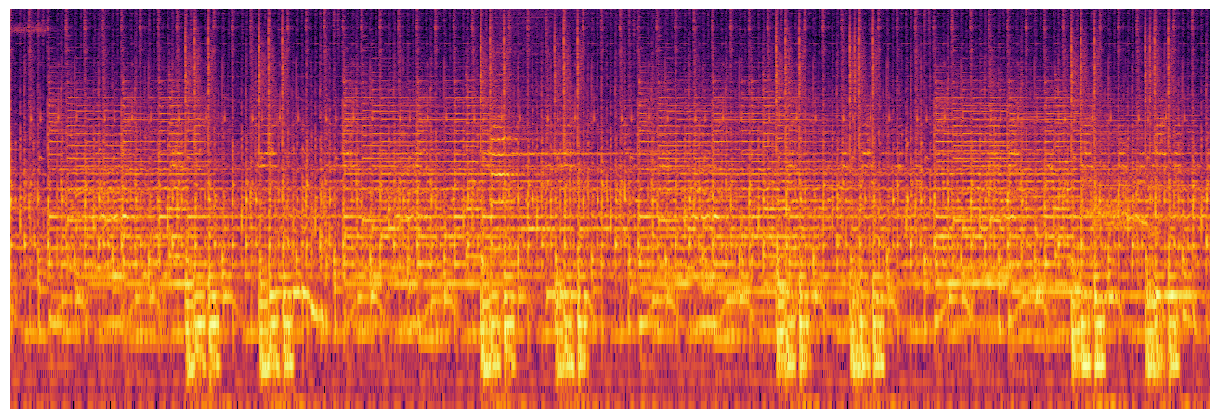

In [7]:
createSpectrogramImages(
	inputDuration=30,
	inputSampleRate=22050,
	inputNFFT=2048,
	inputHopLength=512,
	inputCMAP='inferno'
)